# Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


# Chargement des donnees

In [2]:
# Charger le dataset d'entraînement
file_path = "../home-data-for-ml-course/train.csv"
data = pd.read_csv(file_path)

# Afficher un aperçu des données
print(data.head())
data.info()


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

# ANALYSE DES DONNÉES MANQUANTES

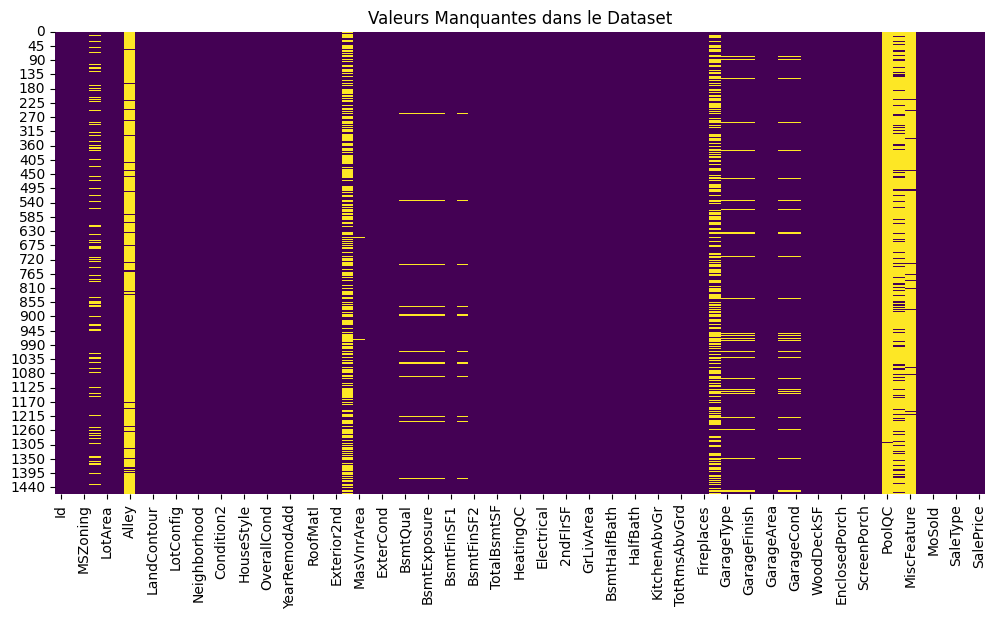

In [3]:
# Sauvegarde des valeurs nulles dans un fichier
missing_values = data.isnull().sum()
missing_values.to_csv("missing_values.txt", sep='\t')

# Visualisation des valeurs manquantes avec une heatmap
plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(), cmap='viridis', cbar=False)
plt.title("Valeurs Manquantes dans le Dataset")
plt.show()

# ANALYSE EXPLORATOIRE

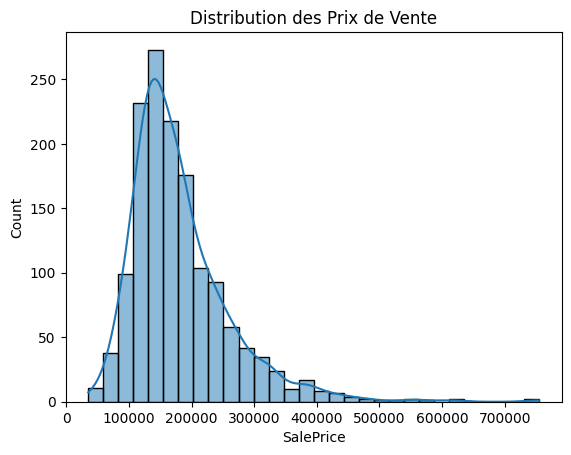

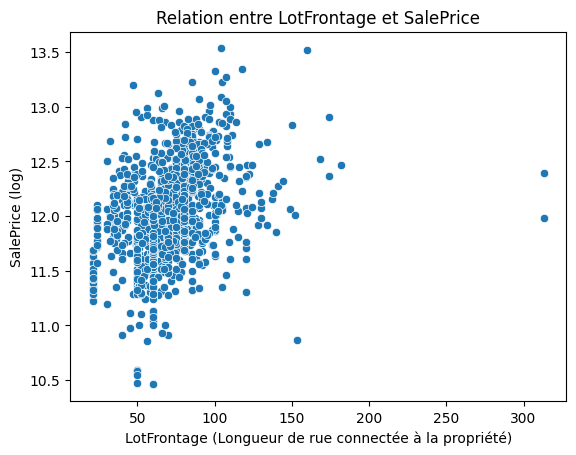

In [4]:
# Distribution des prix de vente
sns.histplot(data['SalePrice'], kde=True, bins=30)
plt.title("Distribution des Prix de Vente")
plt.show()

# Appliquer une transformation logarithmique pour réduire l'asymétrie
data["SalePrice"] = np.log1p(data["SalePrice"])

# Relation entre LotFrontage et SalePrice
sns.scatterplot(data=data, x="LotFrontage", y="SalePrice")
plt.title("Relation entre LotFrontage et SalePrice")
plt.xlabel("LotFrontage (Longueur de rue connectée à la propriété)")
plt.ylabel("SalePrice (log)")
plt.show()

<Axes: xlabel='FireplaceQu', ylabel='SalePrice'>

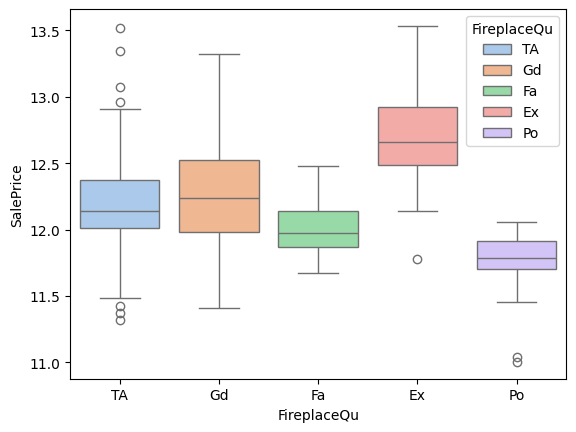

In [5]:
# *** Voir quelques l'effet de quelques variables sur le SalePrice ***

# FireplaceQu
sns.boxplot(data=data, x="FireplaceQu", y="SalePrice", hue="FireplaceQu", palette="pastel")

# IMPUTATION DES DONNÉES MANQUANTES

In [6]:
data["LotFrontage"].fillna(data["LotFrontage"].median(), inplace=True)
data.fillna({
    "BsmtExposure": 'NA', "BsmtFinType1": 'NA', "BsmtFinType2": 'NA', "BsmtCond": 'NA',
    "BsmtQual": 'NA', "GarageType": 'NA', "GarageFinish": 'NA', "GarageQual": 'NA',
    "GarageCond": 'NA', "MiscFeature": 'NA', "Fence": 'NA', "PoolQC": 'NA',
    "FireplaceQu": 'NA', "MasVnrType": 'No_St_Bk', "Alley": 'No_PvGr'
}, inplace=True)
data.dropna(subset=["Electrical", "MasVnrArea"], inplace=True)

data["GarageYrBlt"].fillna(0, inplace=True)  # Mettre 0 pour les maisons sans garage

# ENCODAGE DES VARIABLES CATÉGORIELLES

In [7]:
# Transformer les variables catégorielles en indicatrices (One-Hot Encoding)
data_encoded = pd.get_dummies(data, drop_first=True).astype(int)

# SÉPARATION DES DONNÉES

In [8]:
X = data_encoded.drop(columns=["SalePrice"])
y = data_encoded["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# STANDARDISATION DES VARIABLES NUMÉRIQUES

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reduire les colonnes

Index(['Id', 'BsmtUnfSF', 'GarageYrBlt', 'GarageArea', '2ndFlrSF',
       'YearRemodAdd', 'BsmtFinSF1', 'Fireplaces', 'FireplaceQu_NA',
       'LotFrontage', 'GarageCars', '1stFlrSF', 'LotArea', 'TotalBsmtSF',
       'FullBath', 'OverallQual', 'GrLivArea', 'YearBuilt'],
      dtype='object')


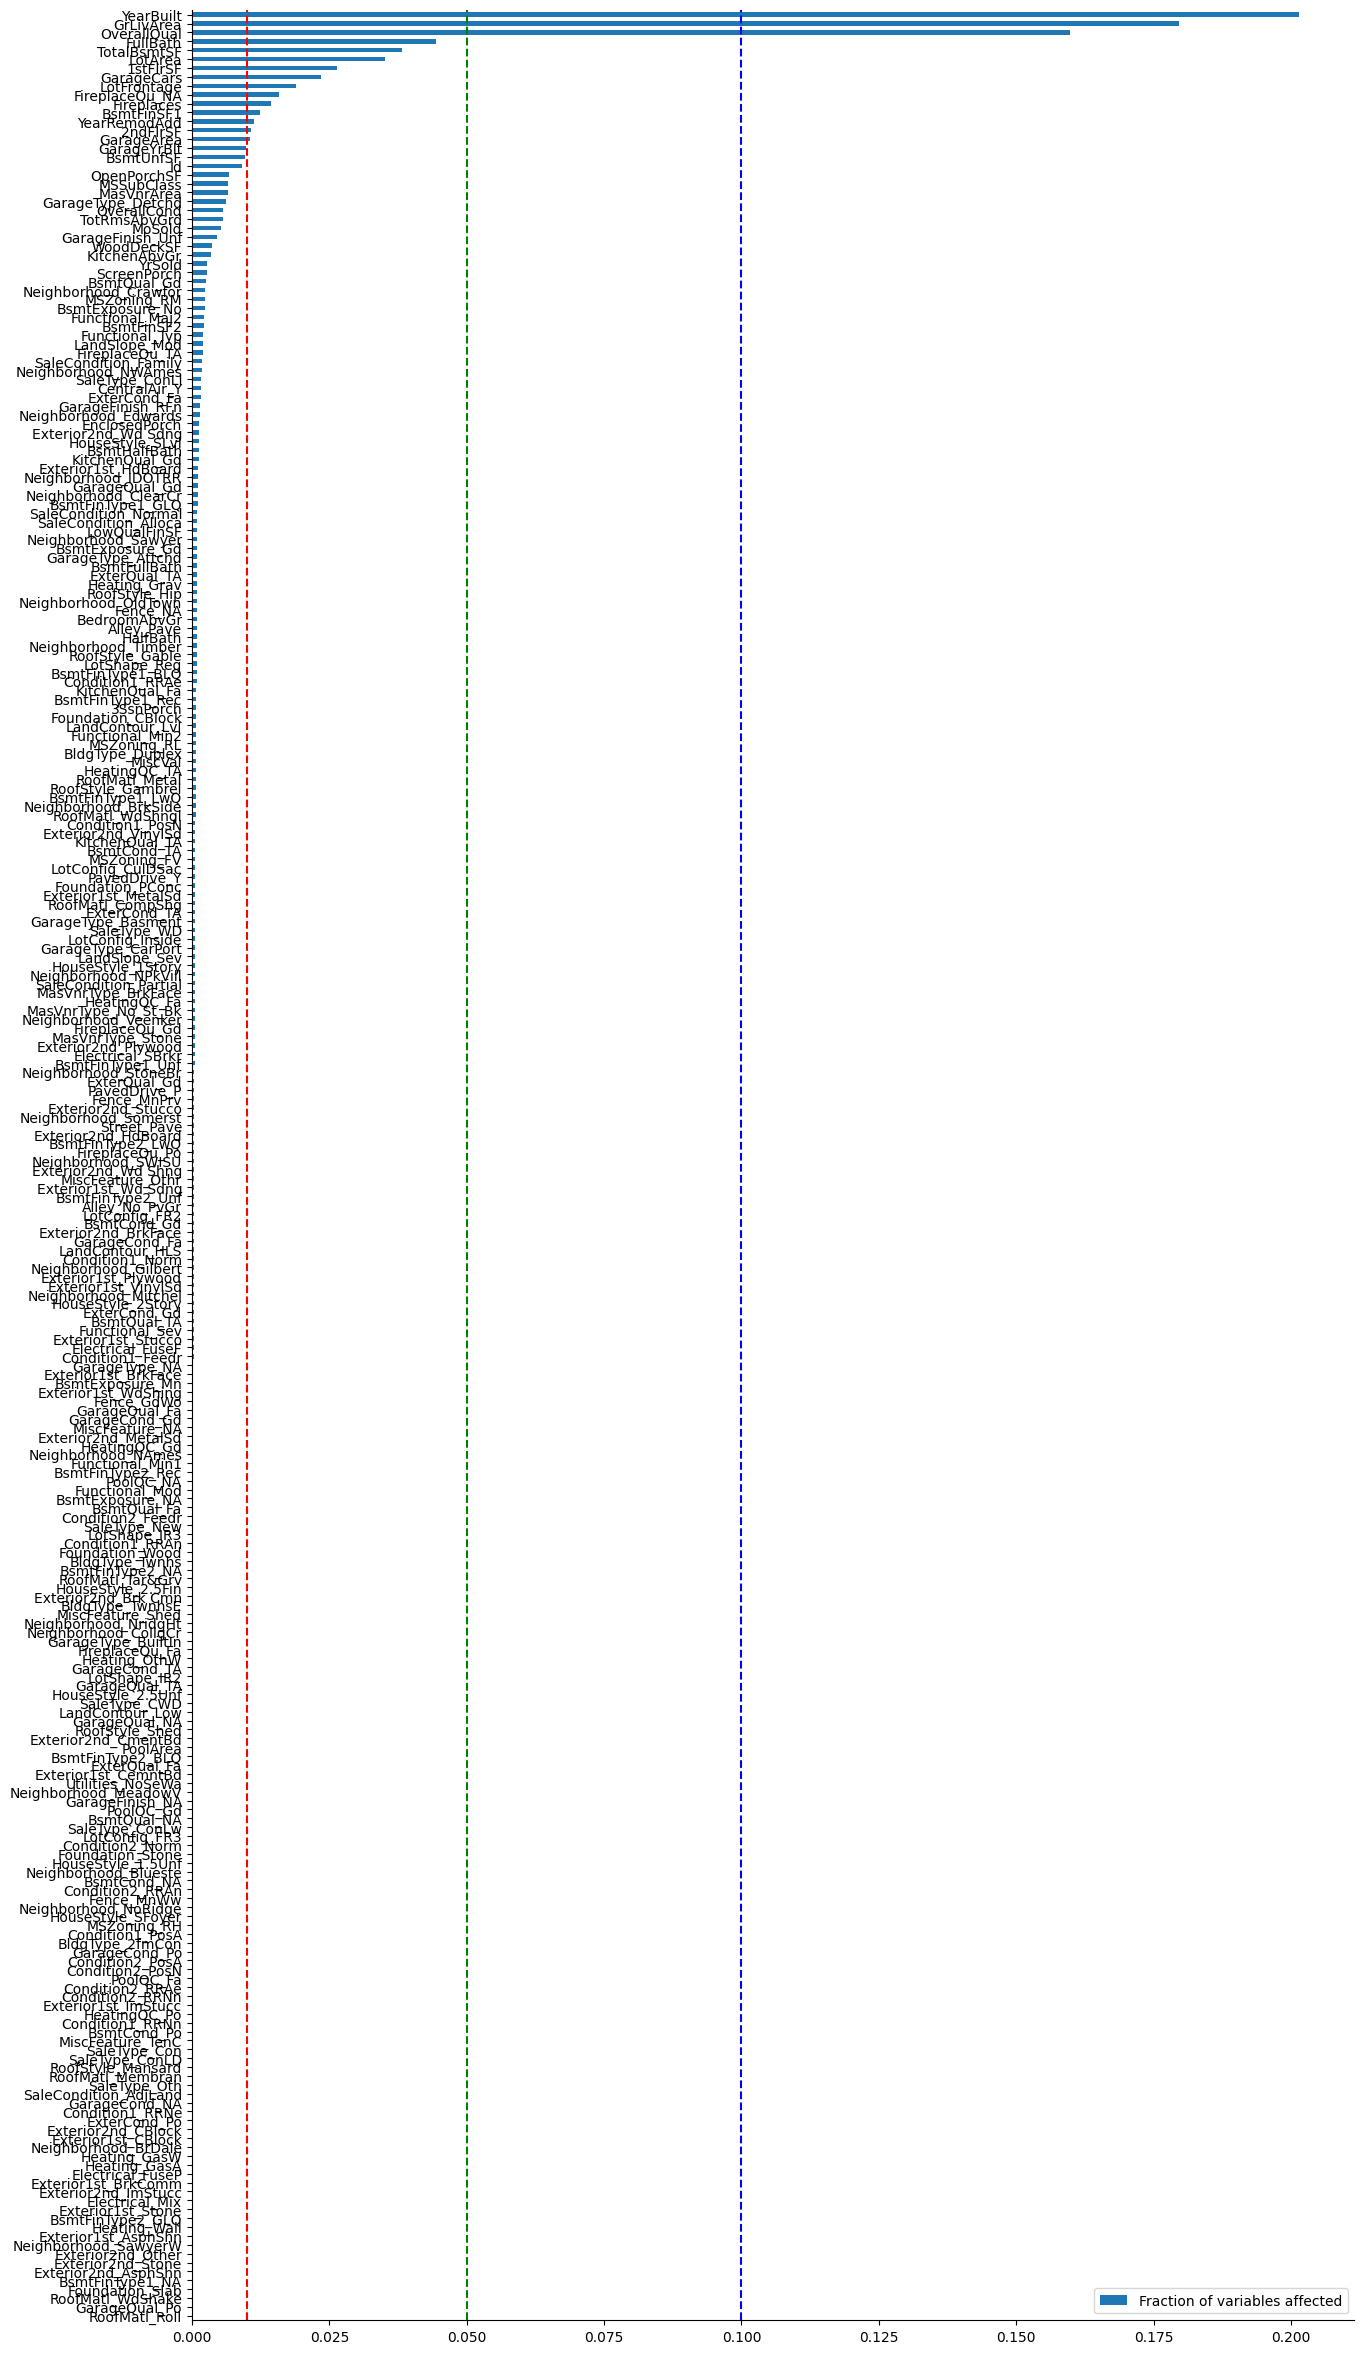

In [10]:
# Convertir en DataFrame avec les bonnes colonnes
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# RandomForest pour importance des features
rf = RandomForestRegressor(n_estimators=100, random_state=8)
rf.fit(X_train, y_train)
feat_scores= pd.DataFrame(
    {"Fraction of variables affected" : rf.feature_importances_},
    index = X.columns
)

feat_scores= feat_scores.sort_values(by = "Fraction of variables affected")
feat_scores.plot(kind = "barh", figsize = (15, 30))
plt.axvline(x=0.01, color="red", linestyle="--", label="Seuil 0.01")
plt.axvline(x=0.05, color="green", linestyle="--", label="Seuil 0.05")
plt.axvline(x=0.1, color="blue", linestyle="--", label="Seuil 0.1")
sns.despine()

important_features = feat_scores[feat_scores["Fraction of variables affected"] > 0.008].index
print(important_features)
# Sélection des variables importantes (par exemple, importance > 0.01)
X_test_reduced = X_test[important_features]
X_train_reduced = X_train[important_features]

# ENTRAÎNEMENT DU MODÈLE XGBOOST

In [11]:
model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=8)
model.fit(X_train_reduced, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=8, ...)

# PRÉDICTIONS ET ÉVALUATION

In [12]:
# y_pred = model.predict(X_test)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# r2 = r2_score(y_test, y_pred)

# print(f"Performance du modèle XGBoost:")
# print(f"- RMSE: {rmse:.2f}")
# print(f"- R²: {r2:.2f}")

In [ ]:
# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initialiser le modèle
xgb = XGBRegressor(random_state=8)

# GridSearch avec validation croisée (3 folds)
grid_search = GridSearchCV(xgb, param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_reduced, y_train)

# Meilleurs paramètres
print(f"Meilleurs paramètres : {grid_search.best_params_}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Meilleurs paramètres : {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.7}
✅ XGBoost optimisé → RMSE: 0.27, R²: 0.74


In [ ]:
# Évaluer le modèle optimisé
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_reduced)

print("Fichier sample_submission.csv enregistré avec succès !")

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"✅ XGBoost optimisé → RMSE: {rmse:.2f}, R²: {r2:.2f}")

Fichier sample_submission.csv enregistré avec succès !
✅ XGBoost optimisé → RMSE: 0.27, R²: 0.74


In [18]:

y_pred = np.expm1(y_pred)


submission = pd.DataFrame({
    "Id": range(1461, 1461 + len(y_pred)),  # Ajuste les IDs en fonction du test set
    "SalePrice": y_pred
})

# Sauvegarde en CSV
submission.to_csv("sample_submission.csv", index=False)